El objetivo de este notebook es crear un recomendador muy sencillo, que sirva de línea base y con el que poder comparar

In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

import os
import sys
print("Python version", sys.version)

import numpy as np
import pandas as pd
import itertools as it

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.autonotebook import tqdm

from src.datasets import daocensus_text, to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent
from src.utils import notebooks as nbutils

sns.set_theme()

Python version 3.9.18 (main, Oct 24 2023, 09:18:18) 
[GCC 11.4.0]


/tmp/ipykernel_3374928/804985562.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Dataset splits config
N_SPLITS: int = 10

# Always 0, just skip the first rows in the CSV to compare with others
SKIP_SPLIT: int = 0

# the second way of making splits
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_SPLITS: int = 10 # Only used to generate baseline graph

K_RECOMMENDATIONS: List[int] = [5, 10, 15]

ORG_NAME: str = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = True

CUTOFF_DATE_STR = ... # Not used

In [3]:
# Parameters
ORG_NAME = "dxDAO - xDXdao"
ORG_PLATFORM = "daostack"
SPLITS_FREQ = "5d"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-08 10:00"
CUTOFF_DATE_STR = None


# Load data

In [4]:
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfptime = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfp = dfp.merge(dfptime, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
print(dfv.info())
print(dfp.info())

,platform,name,id,proposal,deployment,platform_vote,voter,date,choice,weight
0,daostack,dxDAO - xDXdao,a8b902cf-c6ee-5803-bcc6-a4263d832520,c3e93130-1eca-5709-9e86-d6ac3a9c1cad,d3229595-ac4c-55bf-9808-386fc5603bd1,0x000682a038b22925343bd5b9e84acb424a9d14884326...,0x91628ddc3a6ff9b48a2f34fc315d243eb07a9501,2023-03-14 02:47:23,Pass,9.024850e+22
1,daostack,dxDAO - xDXdao,444341a1-178e-5e95-8126-6ad1b7899735,70ec51fe-7cbc-5fbe-8ebf-c886ace664ff,d3229595-ac4c-55bf-9808-386fc5603bd1,0x001cde4d98e26191fc34308be3b51ce50d3eb9561b1b...,0xabd238fa6b6042438fbd22e7d398199080b4224c,2022-05-22 02:09:49,Pass,6.835964e+22
2,daostack,dxDAO - xDXdao,ec7349f9-4a69-5452-a16b-f253c9497211,a501deb0-2016-565e-bd90-9421bc215682,d3229595-ac4c-55bf-9808-386fc5603bd1,0x001e7617a24d4e379669db1b4be94aa5cdc1b735d492...,0x13a0b42b9c180065510615972858bf41d1972a55,2019-08-02 09:25:38,Pass,3.728463e+20
3,daostack,dxDAO - xDXdao,525d31a1-2b08-5f7d-b003-6615630d6b31,370e8509-060d-547c-bd5b-f75f9427b033,d3229595-ac4c-55bf-9808-386fc5603bd1,0x003b53eeeb314ab7fa42f88f8630d7fd6ea17184c1f0...,0xb0e83c2d71a991017e0116d58c5765abc57384af,2020-08-28 12:12:34,Pass,1.801618e+22
4,daostack,dxDAO - xDXdao,eca2ea76-8c1a-53c3-9e32-780160e0daaf,bcf10de1-fb7d-5904-938e-c8942712d595,d3229595-ac4c-55bf-9808-386fc5603bd1,0x003e74b43ea9d833d524b82c47c4e1b2b02f84506bd2...,0x91628ddc3a6ff9b48a2f34fc315d243eb07a9501,2023-03-26 15:16:47,Pass,9.024850e+22
...,...,...,...,...,...,...,...,...,...,...
8474,daostack,dxDAO - xDXdao,a7c026c2-67df-5cd0-980e-eb7b8af9ee86,3b61c687-d085-5224-a7c1-b01948ad164c,5deda895-4531-539a-b7dc-88797456ded7,0xffd8ca7f39b9cf2c8de1914306c1b69e78a958ba90db...,0x6f7c864cc0fc9fb2fe26f53c031d3deec0b8d7d5,2021-05-31 10:15:35,Pass,4.503668e+21
8475,daostack,dxDAO - xDXdao,38fad471-b2ab-558b-bd17-09b34211eb25,af67d1c9-948c-5d7e-8a1a-39fa6d298c40,5deda895-4531-539a-b7dc-88797456ded7,0xffe4fb38b16e8963340aa482be165fb4d650f321975e...,0x5a3992044a131c2f633394065c13ba1b33cdffd9,2021-05-09 07:15:35,Pass,1.760954e+22
8476,daostack,dxDAO - xDXdao,56f8b725-3445-589c-8ab4-fe2a2f7153fe,62fef353-a9ab-5f13-adad-8954274b181c,5deda895-4531-539a-b7dc-88797456ded7,0xffe62001e3e32cabf75e660f91057fc7ed13232c3260...,0xc4a69fbf4511a1377161834cb7a3b8766953db02,2021-10-26 18:37:55,Pass,3.729080e+20
8477,daostack,dxDAO - xDXdao,f543bfe4-a63b-5e3c-91b8-e238cc3ff6a9,e3d91824-bf62-5857-b0f8-9707b07a72d2,5deda895-4531-539a-b7dc-88797456ded7,0xfff1158d5254e39a4f9f1fb14f10c28e77c730f6d608...,0xd97672177e0673227fa102c91bfa8b8cfa825141,2022-05-30 08:49:45,Pass,4.205681e+22


Warning, removing 8479 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8479 entries, 0 to 8478
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   platform       8479 non-null   object        
 1   name           8479 non-null   object        
 2   id             8479 non-null   object        
 3   proposal       8479 non-null   category      
 4   deployment     8479 non-null   object        
 5   platform_vote  8479 non-null   object        
 6   voter          8479 non-null   category      
 7   date           8479 non-null   datetime64[ns]
 8   choice         8479 non-null   object        
 9   weight         8479 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 648.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2226 entries, 0 to 2225
Data columns (total 13 columns):
 #   Column               Non-Null Co

In [5]:
df = to_microsoft(dfv)
df.head()

,userID,itemID,timestamp,rating
0,0x91628ddc3a6ff9b48a2f34fc315d243eb07a9501,c3e93130-1eca-5709-9e86-d6ac3a9c1cad,2023-03-14 02:47:23,1
1,0xabd238fa6b6042438fbd22e7d398199080b4224c,70ec51fe-7cbc-5fbe-8ebf-c886ace664ff,2022-05-22 02:09:49,1
2,0x13a0b42b9c180065510615972858bf41d1972a55,a501deb0-2016-565e-bd90-9421bc215682,2019-08-02 09:25:38,1
3,0xb0e83c2d71a991017e0116d58c5765abc57384af,370e8509-060d-547c-bd5b-f75f9427b033,2020-08-28 12:12:34,1
4,0x91628ddc3a6ff9b48a2f34fc315d243eb07a9501,bcf10de1-fb7d-5904-938e-c8942712d595,2023-03-26 15:16:47,1


# Exploring data

## How much time does each proposal take

Most proposals take a week, but there are a few that take less than 7 days.

count                          2218
mean      9 days 06:19:18.320108205
std      10 days 19:40:49.362318507
min                 0 days 00:50:10
25%          5 days 09:23:06.250000
50%                 6 days 17:47:15
75%          8 days 20:25:46.250000
max               190 days 22:23:20
dtype: object

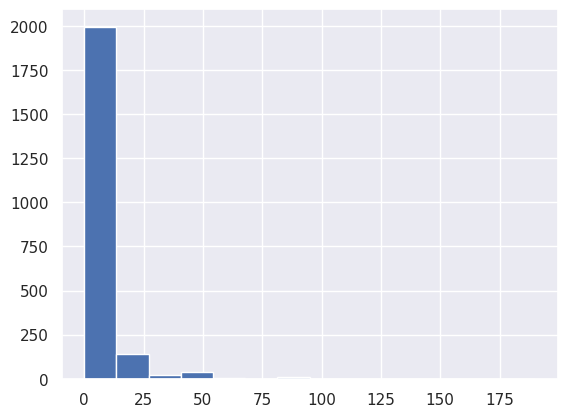

In [6]:
delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
delta.describe()

### Just for MetaCartel, avg proposal length in time

<Axes: xlabel='date'>

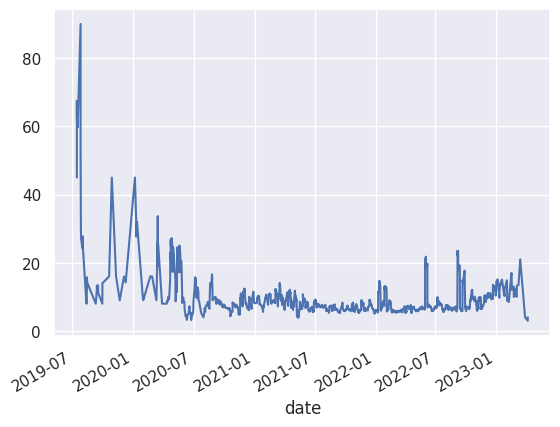

In [7]:
# TODO
_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling('7D').mean().plot()

## What day or the week are proposals created

Monday       422
Wednesday    386
Friday       371
Thursday     361
Tuesday      340
Sunday       182
Saturday     164
Name: start, dtype: int64

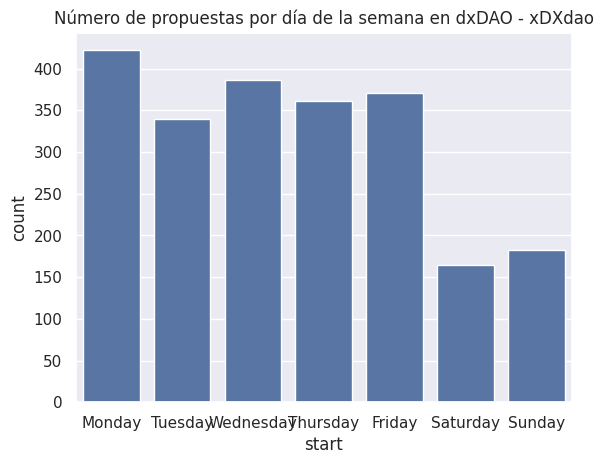

In [8]:
import seaborn as sns

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
dfp['start'].dt.day_name().value_counts()

Friday       1443
Wednesday    1423
Monday       1335
Tuesday      1186
Thursday     1060
Sunday       1042
Saturday      990
Name: date, dtype: int64

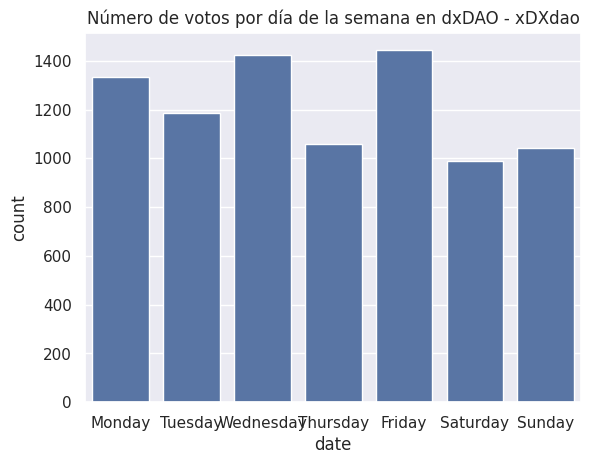

In [9]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de votos por día de la semana en {ORG_NAME}')
dfv['date'].dt.day_name().value_counts()

## Ahora en porcentaje acumulado

<Axes: xlabel='rel_day', ylabel='proposals'>

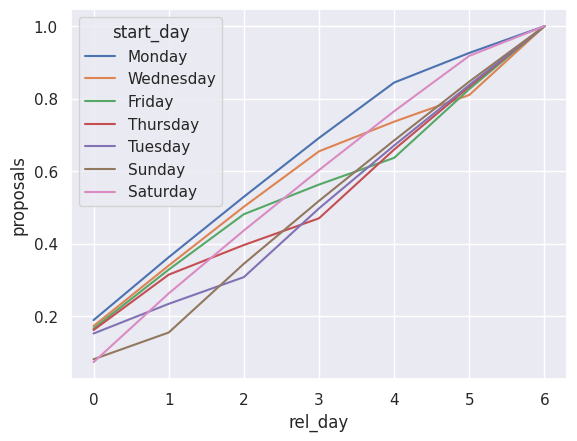

In [10]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfp['start'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='proposals') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='proposals', hue='start_day')

### Same with votes

<Axes: xlabel='rel_day', ylabel='votes'>

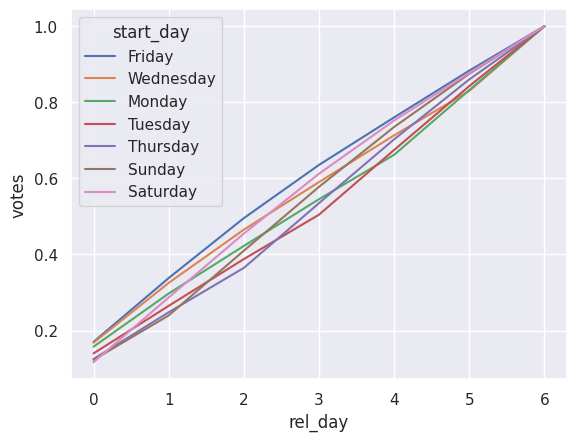

In [11]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfv['date'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='votes') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='votes', hue='start_day')

## How many proposals are created per week

As we can see, there are peaks of over 70 proposals created in a week, using a recommendator can help the users know which proposals to chose.

<Axes: xlabel='start'>

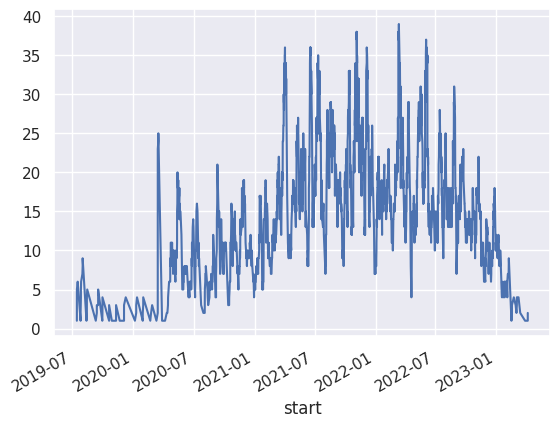

In [12]:
dfp.set_index('start').sort_index().rolling('7d')['id'].count().plot()

## VPP in test per recommendator

In [13]:
freqs = ['W-SUN', 'W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-SAT']
freq = freqs[0]

results = []
for freq in tqdm(freqs, leave=False):
    for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), freq, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'):
        dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
        
        results.append({
            'f': freq,
            't': t,
            # 'proposals in train': dftrain['itemID'].nunique(),
            # 'votes in train': len(dftrain),
            'votes in open proposals (train)': len(dftrain_filter),
            'users in open proposals (train)': dftrain_filter['userID'].nunique(),
            'open proposals': len(openproposals),
            'votes in test': len(dftest),
            'users in test': dftest['userID'].nunique(),
        })

res = pd.DataFrame(results)
res['vpp test'] = res['votes in test'] / res['open proposals']
res['vpu test'] = res['votes in test'] / res['users in test']
res.groupby('f').describe(percentiles=[]).T[freqs]

  0%|          | 0/6 [00:00<?, ?it/s]

f                                           W-SUN       W-MON       W-TUE  \
votes in open proposals (train) count  194.000000  194.000000  194.000000   
                                mean    30.443299   28.711340   28.139175   
                                std     23.755433   22.765740   23.707549   
                                min      0.000000    0.000000    0.000000   
                                50%     25.000000   23.000000   22.000000   
                                max    122.000000  120.000000  139.000000   
users in open proposals (train) count  194.000000  194.000000  194.000000   
                                mean    11.448454   10.835052   10.731959   
                                std      8.124671    7.622139    7.731257   
                                min      0.000000    0.000000    0.000000   
                                50%     10.000000    9.000000    9.000000   
                                max     44.000000   44.000000   44.000000   
open proposals                  count  194.000000  194.000000  194.000000   
                                mean    14.695876   13.953608   13.979381   
                                std      8.010051    7.450904    7.342797   
                                min      0.000000    0.000000    0.000000   
                                50%     14.000000   14.000000   14.000000   
                                max     41.000000   37.000000   31.000000   
votes in test                   count  194.000000  194.000000  194.000000   
                                mean    19.932990   18.195876   20.226804   
                                std     19.604923   16.381551   23.369084   
                                min      0.000000    0.000000    0.000000   
                                50%     14.000000   14.000000   15.000000   
                                max    108.000000   70.000000  235.000000   
users in test                   count  194.000000  194.000000  194.000000   
                                mean     7.051546    6.798969    7.293814   
                                std      5.763690    5.319414    6.035410   
                                min      0.000000    0.000000    0.000000   
                                50%      6.000000    6.000000    7.000000   
                                max     35.000000   36.000000   37.000000   
vpp test                        count  191.000000  192.000000  192.000000   
                                mean     1.229425    1.193081    1.321343   
                                std      0.907811    0.909686    1.366321   
                                min      0.000000    0.000000    0.000000   
                                50%      1.055556    1.000000    1.000000   
                                max      4.900000    6.714286   14.687500   
vpu test                        count  183.000000  185.000000  183.000000   
                                mean     2.580296    2.487502    2.532502   
                                std      1.366288    1.262504    1.222279   
                                min      1.000000    1.000000    1.000000   
                                50%      2.333333    2.200000    2.400000   
                                max      9.500000    8.600000    8.500000   

f                                           W-WED       W-THU       W-SAT  
votes in open proposals (train) count  194.000000  194.000000  194.000000  
                                mean    28.474227   29.123711   30.726804  
                                std     25.053763   23.575590   24.585530  
                                min      0.000000    0.000000    0.000000  
                                50%     23.000000   24.000000   24.500000  
                                max    165.000000  122.000000  123.000000  
users in open proposals (train) count  194.000000  194.000000  194.000000  
                                mean    10.804124   11.154639   11.695876  
    

In [14]:
res.groupby('f').sum().T[freqs]

/tmp/ipykernel_3374928/4276310820.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res.groupby('f').sum().T[freqs]


f,W-SUN,W-MON,W-TUE,W-WED,W-THU,W-SAT
votes in open proposals (train),5906.000000,5570.000000,5459.000000,5524.000000,5650.000000,5961.000000
users in open proposals (train),2221.000000,2102.000000,2082.000000,2096.000000,2164.000000,2269.000000
open proposals,2851.000000,2707.000000,2712.000000,2722.000000,2762.000000,2929.000000
votes in test,3867.000000,3530.000000,3924.000000,3900.000000,3745.000000,4032.000000
users in test,1368.000000,1319.000000,1415.000000,1409.000000,1338.000000,1385.000000
vpp test,234.820264,229.071457,253.697924,249.972245,236.591107,235.357903
vpu test,472.194234,460.187927,463.447954,468.021482,473.554451,482.135613


# Defining the baseline recommendator

Our baseline RecSys will be just recommending the top most famous proposals at time $t$.

In [15]:
from src.baseline import getBaselineRecommendations

"""
def getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):
    bestVotes = train['itemID'].value_counts()
    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
        
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df
"""

# getBaselineRecommendations(folds[0][0], folds[0][1]['userID'].unique(), 3)

"\ndef getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):\n    bestVotes = train['itemID'].value_counts()\n    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])\n\n    if remove_train:\n        df = filter_by(df, train, ['userID', 'itemID'])\n        \n    df = df.groupby('userID').head(k).reset_index(drop=True)\n\n    df['prediction'] = True\n    return df\n"

# Evaluating the baseline recommendator with `timeIntervalSplit`

In [16]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [17]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

In [18]:
from collections import defaultdict

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT, remove_not_in_train_col='userID'))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
# perfectmetrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(folds):
    t = train.timestamp.max()
    print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    print(f"Train votes in open proposals: {len(train_filtered):3}")
    print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False
        
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    print()

===== Training on fold 0 (t: 2019-11-14 18:28:17)  =====
Currently open proposals: 4
Train votes in open proposals:  13
Test votes in open proposals:    4

===== Training on fold 1 (t: 2020-03-17 15:25:23)  =====
Currently open proposals: 25
Train votes in open proposals:  47
Test votes in open proposals:   57



===== Training on fold 2 (t: 2020-07-20 18:36:42)  =====
Currently open proposals: 8
Train votes in open proposals:  15
Test votes in open proposals:    3

===== Training on fold 3 (t: 2020-11-20 00:39:58)  =====
Currently open proposals: 10
Train votes in open proposals:  11
Test votes in open proposals:   18



===== Training on fold 4 (t: 2021-03-25 21:09:40)  =====
Currently open proposals: 27
Train votes in open proposals:  27
Test votes in open proposals:   33

===== Training on fold 5 (t: 2021-07-28 01:24:30)  =====
Currently open proposals: 17
Train votes in open proposals:  33
Test votes in open proposals:   30



===== Training on fold 6 (t: 2021-11-28 13:44:10)  =====
Currently open proposals: 14
Train votes in open proposals:  21
Test votes in open proposals:   10

===== Training on fold 7 (t: 2022-04-01 12:55:40)  =====
Currently open proposals: 13
Train votes in open proposals:  30
Test votes in open proposals:   17



===== Training on fold 8 (t: 2022-08-03 20:09:05)  =====
Currently open proposals: 21
Train votes in open proposals:  56
Test votes in open proposals:   27

===== Training on fold 9 (t: 2022-12-06 00:45:55)  =====
Currently open proposals: 20
Train votes in open proposals:  35
Test votes in open proposals:   15


In [19]:
# from src import paths

# Won't even save it because its not used
# pd.DataFrame(metrics).to_csv(paths.baseline_mp(ORG_NAME, N_SPLITS), index=False)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.240766,0.342594,0.217986,0.424996,0.175028,0.365411,0.260363,0.519114,0.140388,0.380493,0.281359,0.566548,0.499408,0.305492
std,0.220377,0.246388,0.180950,0.271914,0.203209,0.239822,0.201020,0.301433,0.190054,0.246068,0.228286,0.313292,0.203396,0.219808
min,0.072727,0.072704,0.031602,0.083694,0.050000,0.079263,0.038198,0.093750,0.033333,0.087267,0.039062,0.093750,0.300000,0.150000
25%,0.109211,0.150986,0.075893,0.272024,0.060909,0.169968,0.086089,0.302083,0.053889,0.176895,0.093090,0.302083,0.350000,0.175000
50%,0.163333,0.309223,0.174289,0.403865,0.094298,0.358814,0.253325,0.550000,0.073684,0.371030,0.259818,0.585714,0.488312,0.271429
75%,0.267857,0.379482,0.312083,0.526316,0.189286,0.441022,0.312083,0.670162,0.128571,0.441022,0.312083,0.834117,0.553333,0.300000
max,0.800000,0.800000,0.625000,1.000000,0.720000,0.770042,0.625000,1.000000,0.666667,0.830228,0.702165,1.000000,1.000000,0.900000


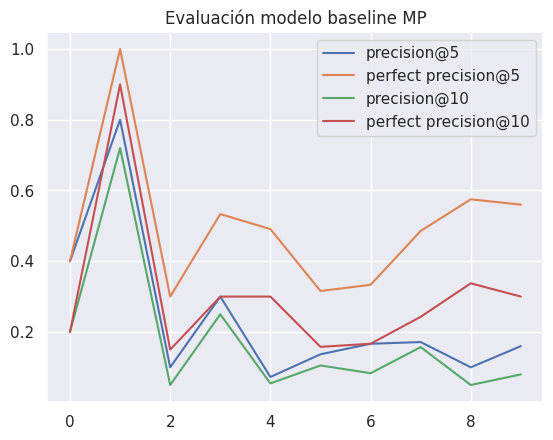

In [20]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,10.000000,1.000000e+01,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,0.499408,1.000000e+00,0.930612,0.930612,0.305492,1.000000e+00,0.984232,0.984232,0.216995,1.000000e+00,0.997647,0.997647
std,0.203396,7.401487e-17,0.146632,0.146632,0.219808,7.401487e-17,0.049862,0.049862,0.187069,7.401487e-17,0.007441,0.007441
min,0.300000,1.000000e+00,0.521161,0.521161,0.150000,1.000000e+00,0.842322,0.842322,0.100000,1.000000e+00,0.976471,0.976471
25%,0.350000,1.000000e+00,0.938312,0.938312,0.175000,1.000000e+00,1.000000,1.000000,0.116667,1.000000e+00,1.000000,1.000000
50%,0.488312,1.000000e+00,0.983333,0.983333,0.271429,1.000000e+00,1.000000,1.000000,0.180952,1.000000e+00,1.000000,1.000000
75%,0.553333,1.000000e+00,1.000000,1.000000,0.300000,1.000000e+00,1.000000,1.000000,0.200000,1.000000e+00,1.000000,1.000000
max,1.000000,1.000000e+00,1.000000,1.000000,0.900000,1.000000e+00,1.000000,1.000000,0.733333,1.000000e+00,1.000000,1.000000


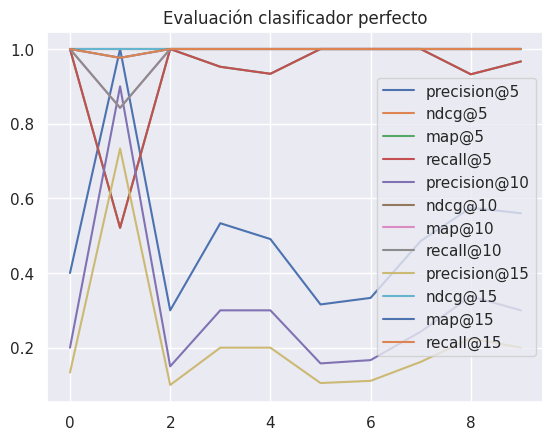

In [21]:
pmdf = pd.DataFrame(perfectmetrics)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

# Evaluation the baseline recommendator with `timeFreqSplit`

In [22]:
from tqdm.autonotebook import tqdm

In [23]:
from functools import partial
import sys

folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(tqdm(folds)):
    t = train.timestamp.max()

    assert not train.empty, f"Train should not be empty on fold {i}"
    # assert not test.empty, f"Test should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i}", file=sys.stderr)
    # print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    # print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    # print(f"Train votes in open proposals: {len(train_filtered):3}")
    # print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    metrics['t'].append(t)
    perfectmetrics['t'].append(t)
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False

        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    # print()

  0%|          | 0/272 [00:00<?, ?it/s]

Warning, empty test fold 1


Warning, empty test fold 8
Warning, empty test fold 10


Warning, empty test fold 17
Warning, empty test fold 18


Warning, empty test fold 21


Warning, empty test fold 24


Warning, empty test fold 27
Warning, empty test fold 29


Warning, empty test fold 31
Warning, empty test fold 32
Warning, empty test fold 33
Warning, empty test fold 34


Warning, empty test fold 37


Warning, empty test fold 41
Warning, empty test fold 42


Warning, empty test fold 46


Warning, empty test fold 50
Warning, empty test fold 52


Warning, empty test fold 72
Warning, empty test fold 74


Warning, empty test fold 75
Warning, empty test fold 76


Warning, empty test fold 91


Warning, empty test fold 264


Warning, empty test fold 268


Warning, empty test fold 270
Warning, empty test fold 271


In [24]:
print(df['timestamp'].min(), df['timestamp'].max())
_folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE, inclusive='right', return_open=True))
_, _, t, _ = _folds[0]
print("t0:", t)
_, _, t, _ = _folds[1]
print("t1:", t)
_, _, t, _ = _folds[-2]
print("t-2:", t)
_, _, t, _ = _folds[-1]
print("t-1:", t)

2019-07-14 19:50:09 2023-04-09 11:34:47


t0: 2019-07-19 00:00:00
t1: 2019-07-24 00:00:00
t-2: 2023-03-30 00:00:00
t-1: 2023-04-04 00:00:00


In [25]:
{ k:len(v) for k,v in metrics.items() }

{'t': 272,
 'precision@5': 272,
 'ndcg@5': 272,
 'map@5': 272,
 'recall@5': 272,
 'precision@10': 272,
 'ndcg@10': 272,
 'map@10': 272,
 'recall@10': 272,
 'precision@15': 272,
 'ndcg@15': 272,
 'map@15': 272,
 'recall@15': 272}

In [26]:
display(dfp['date'].min())
display(df['timestamp'].min())
display(df.sort_values('timestamp').head())
display(dfp.sort_values('date').head())

Timestamp('2019-07-14 12:08:13')

Timestamp('2019-07-14 19:50:09')

,userID,itemID,timestamp,rating
1829,0x166cea845ade3f3b40ea68045d699dee5a645905,82f205b3-1f75-5da5-973a-fc2e324d8719,2019-07-14 19:50:09,1
396,0x166cea845ade3f3b40ea68045d699dee5a645905,b1f193e6-cf73-5a7a-85f3-a84d95c08b97,2019-07-14 19:51:24,1
2421,0xe858a4bf603995a9156edbd25ff06269d997839e,b1f193e6-cf73-5a7a-85f3-a84d95c08b97,2019-07-14 22:24:38,1
2287,0xe858a4bf603995a9156edbd25ff06269d997839e,398d685b-8c4f-5b7d-a7d6-86f1fc78efa4,2019-07-14 22:29:44,1
1811,0xe858a4bf603995a9156edbd25ff06269d997839e,cb124ba8-a044-5790-8da9-43129a92c1f5,2019-07-14 22:31:43,1


,platform,name,platform_deployment,id,deployment,platform_proposal,author,date,title,description,start,end,votes_count
917,daostack,dxDAO - xDXdao,0x519b70055af55a007110b4ff99b0ea33071c720a,402117ef-d822-5417-b935-a032c95298de,d3229595-ac4c-55bf-9808-386fc5603bd1,0x3038b8940eacc02a5555f039fd648dcfbc7d91d700c6...,0xf16294a979a027f297dace2f618cb57bc4bf5d16,2019-07-14 12:08:13,This is a test proposal,# Hello World\n\nThis is a test proposal. Plea...,2019-07-14 12:08:13,2019-08-28 18:08:52,3
1137,daostack,dxDAO - xDXdao,0x519b70055af55a007110b4ff99b0ea33071c720a,b1f193e6-cf73-5a7a-85f3-a84d95c08b97,d3229595-ac4c-55bf-9808-386fc5603bd1,0xae9a111f0089cf0b80ad77c38ea37bc8f77805011f54...,0x9efb62473e702ae623f5efb16a44436107fd87ef,2019-07-14 12:15:47,Add distributed computation tokens [RLC] and [...,"Run on Lots of Computers Token ($RLC, [0x607F4...",2019-07-14 12:15:47,2019-10-12 12:16:22,25
347,daostack,dxDAO - xDXdao,0x519b70055af55a007110b4ff99b0ea33071c720a,82f205b3-1f75-5da5-973a-fc2e324d8719,d3229595-ac4c-55bf-9808-386fc5603bd1,0x8de194855379635110cd6defce61938e404e0bede47b...,0x9efb62473e702ae623f5efb16a44436107fd87ef,2019-07-14 12:18:18,Add HoloToken [HOT] to whitelist,HoloToken [HOT] [0x6c6EE5e31d828De241282B9606C...,2019-07-14 12:18:18,2019-08-25 19:24:15,23
889,daostack,dxDAO - xDXdao,0x519b70055af55a007110b4ff99b0ea33071c720a,cb124ba8-a044-5790-8da9-43129a92c1f5,d3229595-ac4c-55bf-9808-386fc5603bd1,0xd0ca0fa2986182606eb54047a7724cbe0aac19d91979...,0xa343618637bcecb12a723c9007360c305b0507c2,2019-07-14 14:07:23,Remove the locking Eth for Reputation Scheme,Although the locking of Eth and tokens was a g...,2019-07-14 14:07:23,2019-10-12 15:41:19,10
339,daostack,dxDAO - xDXdao,0x519b70055af55a007110b4ff99b0ea33071c720a,398d685b-8c4f-5b7d-a7d6-86f1fc78efa4,d3229595-ac4c-55bf-9808-386fc5603bd1,0xb92d2df99a47244c07a9d7ef73530c273f1d65230dbf...,0x0bba959486e1adde6027f078a82156d7a65f096e,2019-07-14 14:48:30,Give the power to me,I will make the dxDAO great again!,2019-07-14 14:48:30,2019-08-28 14:48:52,19


In [27]:
# Save the data
from pathlib import Path
from src.baseline import write_metrics_baseline

# pd.DataFrame(metrics).set_index('t').to_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_baseline(pd.DataFrame(metrics).set_index('t'), ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000
mean,0.131868,0.225651,0.171080,0.277857,0.099975,0.268526,0.200249,0.392738,0.075421,0.283476,0.207790,0.437529,0.397471,0.219403,0.887199
std,0.137174,0.255369,0.231938,0.312401,0.096387,0.261201,0.238963,0.340705,0.071440,0.261810,0.239748,0.351576,0.209788,0.136336,0.313202
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.033333,0.063736,0.023577,0.100000,0.022222,0.082474,0.035641,0.111919,0.276667,0.138333,1.000000
50%,0.100000,0.142897,0.083333,0.169444,0.087868,0.198989,0.113502,0.333333,0.066667,0.219185,0.125000,0.388194,0.400000,0.200000,1.000000
75%,0.200000,0.320357,0.218982,0.402388,0.140714,0.394743,0.267083,0.595526,0.106667,0.424809,0.271558,0.704470,0.533333,0.289583,1.000000
max,0.666667,1.000000,1.000000,1.000000,0.514286,1.000000,1.000000,1.000000,0.400000,1.000000,1.000000,1.000000,0.900000,0.750000,1.000000


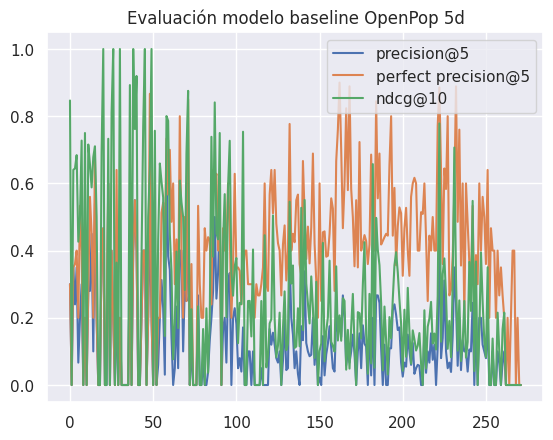

In [28]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf['perfect map@10'] = perfectmetrics['map@10']
mdf[['precision@5', 'perfect precision@5', 'ndcg@10']].plot(title=f'Evaluación modelo baseline OpenPop {SPLITS_FREQ}')
mdf.describe()

In [29]:
mdf[-LAST_SPLITS:].describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.000000,10.000000,10.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.140000,0.070000,0.500000
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.164655,0.082327,0.527046
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.050000,0.500000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.100000,1.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,0.200000,1.000000


,t,model,variable,value
0,2019-07-18 21:19:00,openpop,precision@5,0.30
1,2019-07-23 22:00:12,openpop,precision@5,0.00
2,2019-07-28 20:04:07,openpop,precision@5,0.35
3,2019-08-02 13:41:33,openpop,precision@5,0.24
4,2019-08-07 19:32:50,openpop,precision@5,0.35
...,...,...,...,...
1083,2023-03-14 02:47:23,perfect,recall@5,1.00
1084,2023-03-19 14:08:35,perfect,recall@5,0.00
1085,2023-03-19 14:08:35,perfect,recall@5,1.00
1086,2023-03-29 13:17:11,perfect,recall@5,0.00


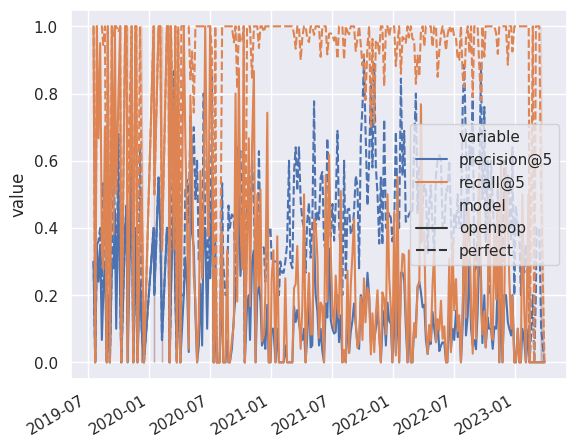

In [30]:
_METRICS = ['precision@5', 'recall@5']

_toplot = pd.concat([
    pd.DataFrame(metrics).assign(model='openpop'),
    pd.DataFrame(perfectmetrics).assign(model='perfect')
])
_toplot = _toplot[['t', 'model'] + _METRICS].melt(id_vars=['t', 'model'])
display(_toplot)

sns.lineplot(_toplot, x='t', y='value', hue='variable', style='model')
plt.xlabel("")
plt.xticks(rotation=30, ha='right');

In [31]:
def _plot_metric(metric):
    _toplot = pd.concat([
        pd.DataFrame(metrics).assign(model='openpop'),
        pd.DataFrame(perfectmetrics).assign(model='perfect')
    ])

    display(_toplot)
    ax = sns.lineplot(_toplot, x='t', y=metric, style='model')
    plt.xlabel("")
    plt.xticks(rotation=30, ha='right');
    return ax

nbutils.download_matplotlib(ax.figure, f'10_all_precision@5_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

,t,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,model
0,2019-07-18 21:19:00,0.30,0.846713,0.791667,1.000000,0.150,0.846713,0.791667,1.0,0.100000,0.846713,0.791667,1.0,openpop
1,2019-07-23 22:00:12,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,openpop
2,2019-07-28 20:04:07,0.35,0.640402,0.520833,1.000000,0.175,0.640402,0.520833,1.0,0.116667,0.640402,0.520833,1.0,openpop
3,2019-08-02 13:41:33,0.24,0.517792,0.456667,0.666667,0.180,0.644417,0.524815,1.0,0.120000,0.644417,0.524815,1.0,openpop
4,2019-08-07 19:32:50,0.35,0.653948,0.523333,0.950000,0.200,0.684151,0.565000,1.0,0.133333,0.684151,0.565000,1.0,openpop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2023-03-14 02:47:23,0.40,1.000000,1.000000,1.000000,0.200,1.000000,1.000000,1.0,0.133333,1.000000,1.000000,1.0,perfect
268,2023-03-19 14:08:35,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,perfect
269,2023-03-19 14:08:35,0.20,1.000000,1.000000,1.000000,0.100,1.000000,1.000000,1.0,0.066667,1.000000,1.000000,1.0,perfect
270,2023-03-29 13:17:11,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,perfect


Cannot show ipywidgets in text

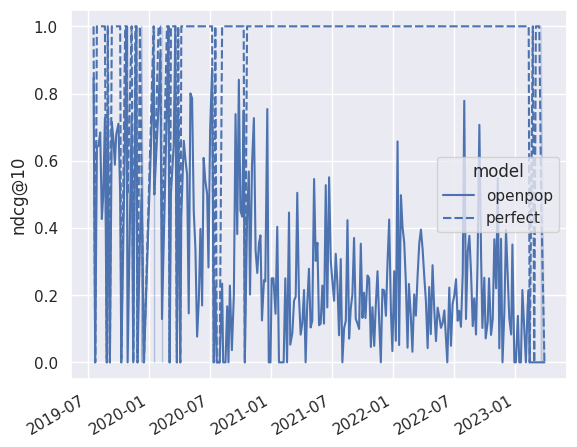

In [32]:
ax = _plot_metric('ndcg@10')
nbutils.download_matplotlib(ax.figure, f'10_all_ndcg@10_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

In [33]:
pmdf

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
0,0.400000,1.0,1.000000,1.000000,0.200000,1.0,1.000000,1.000000,0.133333,1.0,1.000000,1.000000
1,1.000000,1.0,0.521161,0.521161,0.900000,1.0,0.842322,0.842322,0.733333,1.0,0.976471,0.976471
2,0.300000,1.0,1.000000,1.000000,0.150000,1.0,1.000000,1.000000,0.100000,1.0,1.000000,1.000000
3,0.533333,1.0,0.952381,0.952381,0.300000,1.0,1.000000,1.000000,0.200000,1.0,1.000000,1.000000
4,0.490909,1.0,0.933622,0.933622,0.300000,1.0,1.000000,1.000000,0.200000,1.0,1.000000,1.000000
5,0.315789,1.0,1.000000,1.000000,0.157895,1.0,1.000000,1.000000,0.105263,1.0,1.000000,1.000000
6,0.333333,1.0,1.000000,1.000000,0.166667,1.0,1.000000,1.000000,0.111111,1.0,1.000000,1.000000
7,0.485714,1.0,1.000000,1.000000,0.242857,1.0,1.000000,1.000000,0.161905,1.0,1.000000,1.000000
8,0.575000,1.0,0.932292,0.932292,0.337500,1.0,1.000000,1.000000,0.225000,1.0,1.000000,1.000000
9,0.560000,1.0,0.966667,0.966667,0.300000,1.0,1.000000,1.000000,0.200000,1.0,1.000000,1.000000


,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000
mean,0.397471,0.889706,0.863068,0.863068,0.219403,0.889706,0.887199,0.887199,0.148460,0.889706,0.889561,0.889561
std,0.209788,0.313833,0.309511,0.309511,0.136336,0.313833,0.313202,0.313202,0.096768,0.313833,0.313786,0.313786
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.276667,1.000000,0.928075,0.928075,0.138333,1.000000,1.000000,1.000000,0.092222,1.000000,1.000000,1.000000
50%,0.400000,1.000000,1.000000,1.000000,0.200000,1.000000,1.000000,1.000000,0.133333,1.000000,1.000000,1.000000
75%,0.533333,1.000000,1.000000,1.000000,0.289583,1.000000,1.000000,1.000000,0.195833,1.000000,1.000000,1.000000
max,0.900000,1.000000,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,0.633333,1.000000,1.000000,1.000000


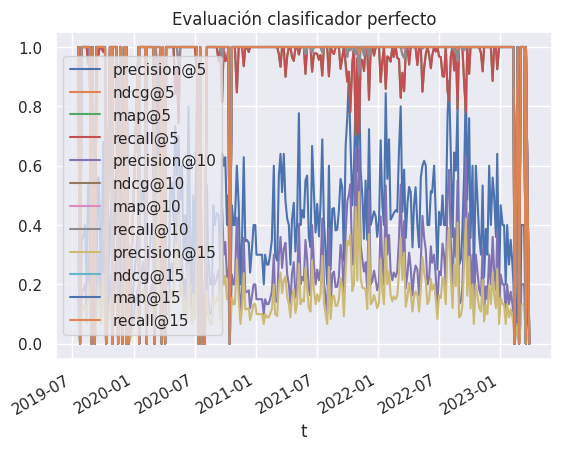

In [34]:
from src.baseline import write_metrics_perfect

pmdf = pd.DataFrame(perfectmetrics).set_index('t')

# pmdf.to_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_perfect(pmdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

## Exploring the folds

In [35]:
print(f"There are {len(folds)} folds")
print(f"From {df['timestamp'].min()} to {df['timestamp'].max()}")

full_len = len(df)
fold_len = []
for tr, ts, t, open_proposals in timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, return_open=True, normalize=SPLITS_NORMALIZE):
    fold_len.append({
        't': t,
        'train': len(tr),
        'test': len(ts),
        'open': len(open_proposals),
        'test users': ts['userID'].nunique(),
        'test vpv': ts['userID'].nunique() / len(ts) if len(ts) else np.NaN,
        'test vpp': ts['userID'].nunique() / ts['itemID'].nunique() if len(ts) else np.NaN,
        # 't_train_min': tr['timestamp'].min(),
        # 't_train_max': tr['timestamp'].max(),
        't_test_min': ts['timestamp'].min(),
        't_test_max': ts['timestamp'].max(),
    })

fold_len = pd.DataFrame(fold_len)
fold_len.describe()

There are 272 folds
From 2019-07-14 19:50:09 to 2023-04-09 11:34:47


,train,test,open,test users,test vpv,test vpp
count,272.000000,272.000000,272.000000,272.000000,248.000000,248.000000
mean,3716.172794,19.268382,14.191176,6.952206,0.490483,1.057377
std,2920.126594,22.605179,7.660716,5.895266,0.227304,0.959914
min,39.000000,0.000000,0.000000,0.000000,0.105263,0.285714
25%,1162.000000,5.000000,9.000000,3.000000,0.333333,0.600000
50%,2894.500000,13.000000,14.000000,6.000000,0.454545,0.870833
75%,6588.250000,29.000000,19.000000,10.000000,0.600000,1.200000
max,8441.000000,239.000000,41.000000,38.000000,1.000000,12.000000


In [36]:
fold_len

,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max
0,2019-07-19,39,10,6,6,0.600000,1.500000,2019-07-19 05:06:16,2019-07-23 22:00:12
1,2019-07-24,49,5,6,5,1.000000,1.250000,2019-07-25 10:17:39,2019-07-26 23:51:38
2,2019-07-29,85,21,12,12,0.571429,1.200000,2019-07-29 08:22:37,2019-08-02 09:25:38
3,2019-08-03,121,11,15,6,0.545455,1.000000,2019-08-03 19:11:52,2019-08-07 19:32:50
4,2019-08-08,132,31,14,10,0.322581,0.769231,2019-08-08 08:19:51,2019-08-12 07:34:36
...,...,...,...,...,...,...,...,...,...
267,2023-03-15,8437,2,6,1,0.500000,0.500000,2023-03-16 17:38:47,2023-03-19 14:08:35
268,2023-03-20,8439,0,2,0,NaN,NaN,NaT,NaT
269,2023-03-25,8439,1,2,1,1.000000,1.000000,2023-03-26 15:16:47,2023-03-26 15:16:47
270,2023-03-30,8441,0,2,0,NaN,NaN,NaT,NaT


In [37]:
# Get folds with more than 10 open proposals
MIN_OPEN = 10 # obviously, to test @10, we need 10 open proposals
MIN_USERS = 5
MIN_VPP = 1

MIN_FOLDS = 10 + 1

# fold_len['min_open'] = (fold_len['open'] >= MIN_OPEN) & (fold_len['test users'] >= MIN_USERS)
fold_len['min'] = (fold_len['open'] >= MIN_OPEN)
print("There are", fold_len['min'].sum(), "folds that could be used")
fold_len['min_window'] = fold_len.rolling(MIN_FOLDS)['min'].sum() >= MIN_FOLDS
fold_len[fold_len['min_window']].tail(20)

There are 201 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window
236,2022-10-11,8031,9,14,3,0.333333,0.428571,2022-10-11 10:20:50,2022-10-14 14:16:30,True,True
237,2022-10-16,8041,8,12,4,0.500000,0.800000,2022-10-17 10:04:45,2022-10-20 15:18:50,True,True
238,2022-10-21,8052,18,19,5,0.277778,0.454545,2022-10-21 14:16:11,2022-10-25 17:37:10,True,True
239,2022-10-26,8073,17,18,9,0.529412,1.500000,2022-10-26 08:12:10,2022-10-30 13:14:50,True,True
240,2022-10-31,8096,31,16,17,0.548387,2.428571,2022-10-31 07:37:10,2022-11-04 05:11:05,True,True
241,2022-11-05,8166,13,21,8,0.615385,0.666667,2022-11-05 19:14:35,2022-11-09 23:19:35,True,True
242,2022-11-10,8201,29,19,9,0.310345,1.000000,2022-11-10 08:19:35,2022-11-14 08:56:20,True,True
243,2022-11-15,8232,12,12,9,0.750000,1.500000,2022-11-15 07:22:15,2022-11-19 13:44:35,True,True
244,2022-11-20,8248,29,14,15,0.517241,1.875000,2022-11-20 07:19:23,2022-11-23 18:46:11,True,True
245,2022-11-25,8278,5,11,3,0.600000,0.600000,2022-11-25 14:46:11,2022-11-28 12:00:59,True,True


In [38]:
fold_len['min2'] = fold_len['min'] & (fold_len['test vpp'] >= MIN_VPP)
print("There are", fold_len['min2'].sum(), "folds that could be used")
fold_len['min2_window'] = fold_len.rolling(MIN_FOLDS)['min2'].sum() >= MIN_FOLDS
fold_len[fold_len['min2_window']].tail(20)

There are 77 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window,min2,min2_window


            train  test  i
t                         
2019-07-19     39    10  0
2019-07-24     49     5  1
2019-07-29     85    21  2
2019-08-03    121    11  3
2019-08-08    132    31  4
2019-08-13    165     6  5
2019-08-18    185    16  6
2019-08-23    201    10  7
2019-08-28    211     1  8
2019-09-02    212     2  9


Cannot show ipywidgets in text

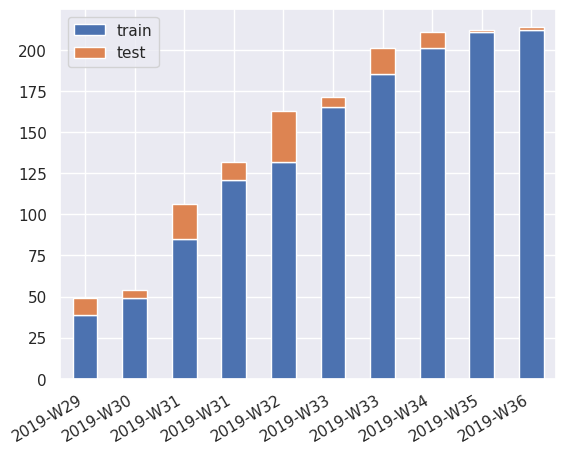

In [39]:
FIRST_FOLDS = 10
LAST_FOLDS = 0

# Bosquejo usando pandas.plot
_toplot = fold_len.set_index('t')[['train', 'test']]
_toplot['i'] = fold_len.index

_toplot = _toplot[ (_toplot['i'] < FIRST_FOLDS) | (_toplot['i'] > (len(_toplot) - LAST_FOLDS)) ]

print(_toplot)
ax = _toplot[['train', 'test']].plot.bar(stacked=True)
ax.set_xticks(np.arange(10), _toplot.index.strftime('%G-W%V'), rotation=30, ha='right')
ax.set_xlabel("")

nbutils.download_matplotlib(ax.figure, f'10_first_folds_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

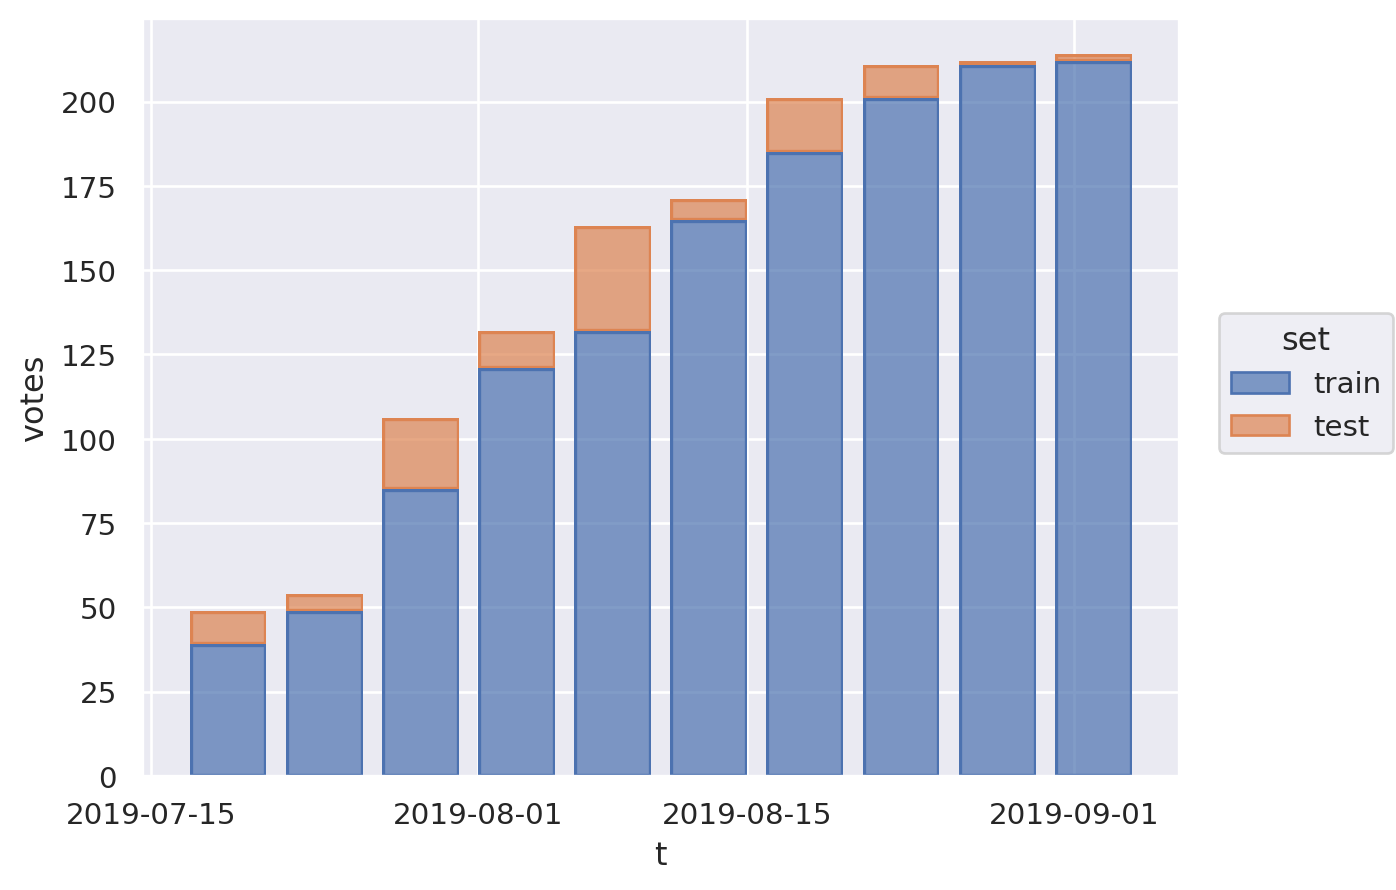

In [40]:
# Definitivo en seaborn
import seaborn.objects as so

_toplot = fold_len.assign(i=fold_len.index).melt(id_vars=['t', 'i'], value_vars=['train', 'test'], var_name='set', value_name='votes')
_toplot = _toplot[_toplot['i'] < FIRST_FOLDS]
so.Plot(_toplot, x='t', y='votes', color='set').add(so.Bar(), so.Stack())